In [1]:
import pandas as pd
import sys
import os
import numpy as np
import base64
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights")
from MedImageInsight.medimageinsightmodel import MedImageInsight
sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights/predictions")
from utils import read_image, zero_shot_prediction, extract_findings_and_impressions, create_wandb_run_name


/mnt/data2/datasets_lfay/MedImageInsights/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes = ["pneumonia", "no finding"]
views = ["frontal", "lateral"]

# Prompt templates
prompt_templates = [
    "",
    "chest ",
    "x-ray ",
    "chest x-ray ",
    "chest x-ray anteroposterior ",
    "chest x-ray posteroanterior "
]


In [3]:
# generate prompts for each class
template_disease = [p+ "Pneumonia" for p in prompt_templates]
template_no_disease = [p + "No Pneumonia" for p in prompt_templates]
template_no_disease = [p + "No Finding" for p in prompt_templates]


In [4]:
    diseases = [
        'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
        'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
    ]

In [5]:
PATH_TO_DATA = "/mnt/data2/datasets_lfay/MedImageInsights/data"
read_path = PATH_TO_DATA+"/MIMIC-v1.0-512/"

df_train = pd.read_csv(read_path + "train.csv")

df_disease = df_train[df_train["Pneumonia"] == 1]
# single disease
single_disease = diseases.copy()
single_disease.remove("Pneumonia")
df_disease = df_train[(df_train["Pneumonia"] == 1) & (df_train[single_disease] == 0).all(axis=1)]


df_no_disease = df_train[df_train["Pneumonia"] == 0]

# embedding for no finding
df_no_disease = df_train[df_train["No Finding"] == 1]

In [6]:
# Extract full report
report_disease = df_disease["report"].copy()
report_disease = report_disease.dropna()
report_disease = report_disease.sample(10, random_state=42).tolist()

report_no_disease = df_no_disease["report"].copy()
report_no_disease = report_no_disease.dropna()
report_no_disease = report_no_disease.sample(10, random_state=42).tolist()

In [7]:
# Extract Findings 
findings_disease = df_disease.section_findings.copy()
findings_disease = findings_disease.dropna().reset_index(drop=True)
findings_disease = findings_disease.sample(10, random_state=42).tolist()

findings_no_disease = df_no_disease.section_findings.copy()
findings_no_disease = findings_no_disease.dropna().reset_index(drop=True)
findings_no_disease = findings_no_disease.sample(10, random_state=42).tolist()

In [8]:
# Extract Impression
impression_disease = df_disease.section_impression.copy()
impression_disease = impression_disease.dropna().reset_index(drop=True)
impression_disease = impression_disease.sample(10, random_state=42).tolist()

impression_no_disease = df_no_disease.section_impression.copy()
impression_no_disease = impression_no_disease.dropna().reset_index(drop=True)
impression_no_disease = impression_no_disease.sample(10, random_state=42).tolist()

In [9]:
df_findings_impression_disease = df_disease[["section_findings", "section_impression"]].copy()
df_findings_impression_disease.dropna(inplace=True)

findings_impression_disease = (
    df_findings_impression_disease.section_findings.str.cat(
        df_findings_impression_disease.section_impression, sep=" ", na_rep=""
    )
    .sample(10, random_state=42).tolist()
)

df_findings_impression_no_disease = df_no_disease[["section_findings", "section_impression"]].copy()
df_findings_impression_no_disease.dropna(inplace=True)

findings_impression_no_disease = (
    df_findings_impression_no_disease.section_findings.str.cat(
        df_findings_impression_no_disease.section_impression, sep=" ", na_rep=""
    )
    .sample(10, random_state=42).tolist()
)

In [10]:
# 1. Prompt Template + All reports
prompts_disease = template_disease + report_disease + findings_disease + impression_disease + findings_impression_disease
prompts_no_disease = template_no_disease + report_no_disease + findings_no_disease + impression_no_disease + findings_impression_no_disease

print (len(prompts_disease))
print (len(prompts_no_disease))

# 2. Prompt Template
prompts_disease_template = template_disease
prompts_no_disease_template = template_no_disease

print (len(prompts_disease_template))
print (len(prompts_no_disease_template))

# 3. Reports
prompts_disease_report = report_disease + findings_disease + impression_disease + findings_impression_disease
prompts_no_disease_report = report_no_disease + findings_no_disease + impression_no_disease + findings_impression_no_disease

print (len(prompts_disease_report))
print (len(prompts_no_disease_report))


46
46
6
6
40
40


In [11]:
## 3. Initialize model
classifier = MedImageInsight(
    model_dir="/mnt/data2/datasets_lfay/MedImageInsights/MedImageInsight/2024.09.27",
    vision_model_name="medimageinsigt-v1.0.0.pt",
    language_model_name="language_model.pth"
)
classifier.load_model()


Model loaded successfully on device: cuda


In [12]:
#1. Prompt Template + All reports 
embeddings_disease = classifier.encode(texts=prompts_disease)["text_embeddings"]
embeddings_no_disease = classifier.encode(texts=prompts_no_disease)["text_embeddings"]
embeddings = np.concatenate([embeddings_no_disease, embeddings_disease], axis=0)
print(embeddings_disease.shape)
print(embeddings_no_disease.shape)
print(embeddings.shape)

#2. Prompt Template
embeddings_disease_template = classifier.encode(texts=prompts_disease_template)["text_embeddings"]
embeddings_no_disease_template = classifier.encode(texts=prompts_no_disease_template)["text_embeddings"]
embeddings_template = np.concatenate([embeddings_no_disease_template, embeddings_disease_template], axis=0)
print(embeddings_disease_template.shape)
print(embeddings_no_disease_template.shape)
print(embeddings_template.shape)

#3. Reports
embeddings_disease_report = classifier.encode(texts=prompts_disease_report)["text_embeddings"]
embeddings_no_disease_report = classifier.encode(texts=prompts_no_disease_report)["text_embeddings"]
embeddings_report = np.concatenate([embeddings_no_disease_report, embeddings_disease_report], axis=0)
print(embeddings_disease_report.shape)
print(embeddings_no_disease_report.shape)
print(embeddings_report.shape)




(46, 1024)
(46, 1024)
(92, 1024)
(6, 1024)
(6, 1024)
(12, 1024)
(40, 1024)
(40, 1024)
(80, 1024)


In [13]:
# save embeddings
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/embeddings_92_no_finding.npy", embeddings)
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/embeddings_92_no_finding_template.npy", embeddings_template)
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/embeddings_92_no_finding_report.npy", embeddings_report)


In [14]:
# Step 2: Compute average embeddings for each class
# 1. Prompt Template + All reports
average_embedding_disease = np.mean(embeddings_disease, axis=0)
average_embedding_no_disease = np.mean(embeddings_no_disease, axis=0)
average_embedding = np.stack([average_embedding_no_disease,average_embedding_disease], axis=0)
print(average_embedding_disease.shape)
print(average_embedding_no_disease.shape)
print(average_embedding.shape)


# 2. Prompt Template
average_embedding_disease_template = np.mean(embeddings_disease_template, axis=0)
average_embedding_no_disease_template = np.mean(embeddings_no_disease_template, axis=0)
average_embedding_template = np.stack([average_embedding_no_disease_template,average_embedding_disease_template], axis=0)
print(average_embedding_disease_template.shape)
print(average_embedding_no_disease_template.shape)
print(average_embedding_template.shape)

# 3. Reports
average_embedding_disease_report = np.mean(embeddings_disease_report, axis=0)
average_embedding_no_disease_report = np.mean(embeddings_no_disease_report, axis=0)
average_embedding_report = np.stack([average_embedding_no_disease_report,average_embedding_disease_report], axis=0)
print(average_embedding_disease_report.shape)
print(average_embedding_no_disease_report.shape)
print(average_embedding_report.shape)


(1024,)
(1024,)
(2, 1024)
(1024,)
(1024,)
(2, 1024)
(1024,)
(1024,)
(2, 1024)


In [15]:
# save average embeddings
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/average_embeddings_2_no_finding.npy", average_embedding)
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/average_embeddings_2_no_finding_template.npy", average_embedding_template)
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/average_embeddings_2_no_finding_report.npy", average_embedding_report)

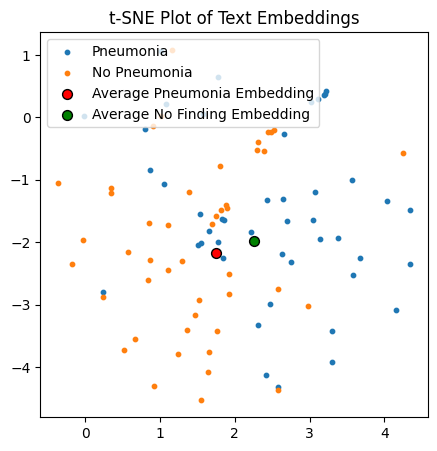

In [32]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load and organize data
embeddings = np.load("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/embeddings_92_no_finding.npy")
embeddings_disease = embeddings[46:]
embeddings_no_disease = embeddings[:46]
average_embedding = np.load("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/average_embeddings_2_no_finding.npy")
average_embedding_disease = average_embedding[0]
average_embedding_no_disease = average_embedding[1].reshape(1, -1)

# Add average embeddings to their respective groups
embeddings_disease = np.concatenate([embeddings_disease, average_embedding_disease.reshape(1, -1)], axis=0)
embeddings_no_disease = np.concatenate([embeddings_no_disease, average_embedding_no_disease], axis=0)

# Combine data for t-SNE
all_embeddings = np.vstack([embeddings_disease, embeddings_no_disease])
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
all_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Split back for visualization
embeddings_disease_tsne = all_embeddings_tsne[:len(embeddings_disease)]
embeddings_no_disease_tsne = all_embeddings_tsne[len(embeddings_disease):]

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(embeddings_disease_tsne[:-1, 0], embeddings_disease_tsne[:-1, 1], label="Pneumonia", s=10, color="C0")
plt.scatter(embeddings_no_disease_tsne[:-1, 0], embeddings_no_disease_tsne[:-1, 1], label="No Pneumonia", s=10, color="C1")
plt.scatter(
    embeddings_disease_tsne[-1, 0], embeddings_disease_tsne[-1, 1], 
    label="Average Pneumonia Embedding", color="red", s=50, edgecolors="black"
)
plt.scatter(
    embeddings_no_disease_tsne[-1, 0], embeddings_no_disease_tsne[-1, 1], 
    label="Average No Finding Embedding", color="green", s=50, edgecolors="black"
)
plt.legend(loc="best")
plt.title("t-SNE Plot of Text Embeddings")
plt.show()


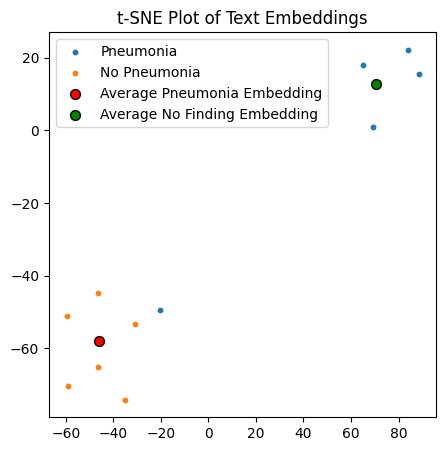

In [28]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load and organize data
embeddings = np.load("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/embeddings_92_no_finding_template.npy")
embeddings_disease = embeddings[7:]
embeddings_no_disease = embeddings[:6]
average_embedding = np.load("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/average_embeddings_2_no_finding_template.npy")
average_embedding_disease = average_embedding[0]
average_embedding_no_disease = average_embedding[1].reshape(1, -1)

# Add average embeddings to their respective groups
embeddings_disease = np.concatenate([embeddings_disease, average_embedding_disease.reshape(1, -1)], axis=0)
embeddings_no_disease = np.concatenate([embeddings_no_disease, average_embedding_no_disease], axis=0)

# Combine data for t-SNE
all_embeddings = np.vstack([embeddings_disease, embeddings_no_disease])
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
all_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Split back for visualization
embeddings_disease_tsne = all_embeddings_tsne[:len(embeddings_disease)]
embeddings_no_disease_tsne = all_embeddings_tsne[len(embeddings_disease):]

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(embeddings_disease_tsne[:-1, 0], embeddings_disease_tsne[:-1, 1], label="Pneumonia", s=10, color="C0")
plt.scatter(embeddings_no_disease_tsne[:-1, 0], embeddings_no_disease_tsne[:-1, 1], label="No Pneumonia", s=10, color="C1")
plt.scatter(
    embeddings_disease_tsne[-1, 0], embeddings_disease_tsne[-1, 1], 
    label="Average Pneumonia Embedding", color="red", s=50, edgecolors="black"
)
plt.scatter(
    embeddings_no_disease_tsne[-1, 0], embeddings_no_disease_tsne[-1, 1], 
    label="Average No Finding Embedding", color="green", s=50, edgecolors="black"
)
plt.legend(loc="best")
plt.title("t-SNE Plot of Text Embeddings")
plt.show()
